In [ ]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.14.0


In [ ]:
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/labels.csv")
labels = labels_csv.breed.to_numpy()
unique_breeds = np.unique(labels)
filenames = ["/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/train/" +id+ ".jpg" for id in labels_csv.id]
filenames[:5]

['/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

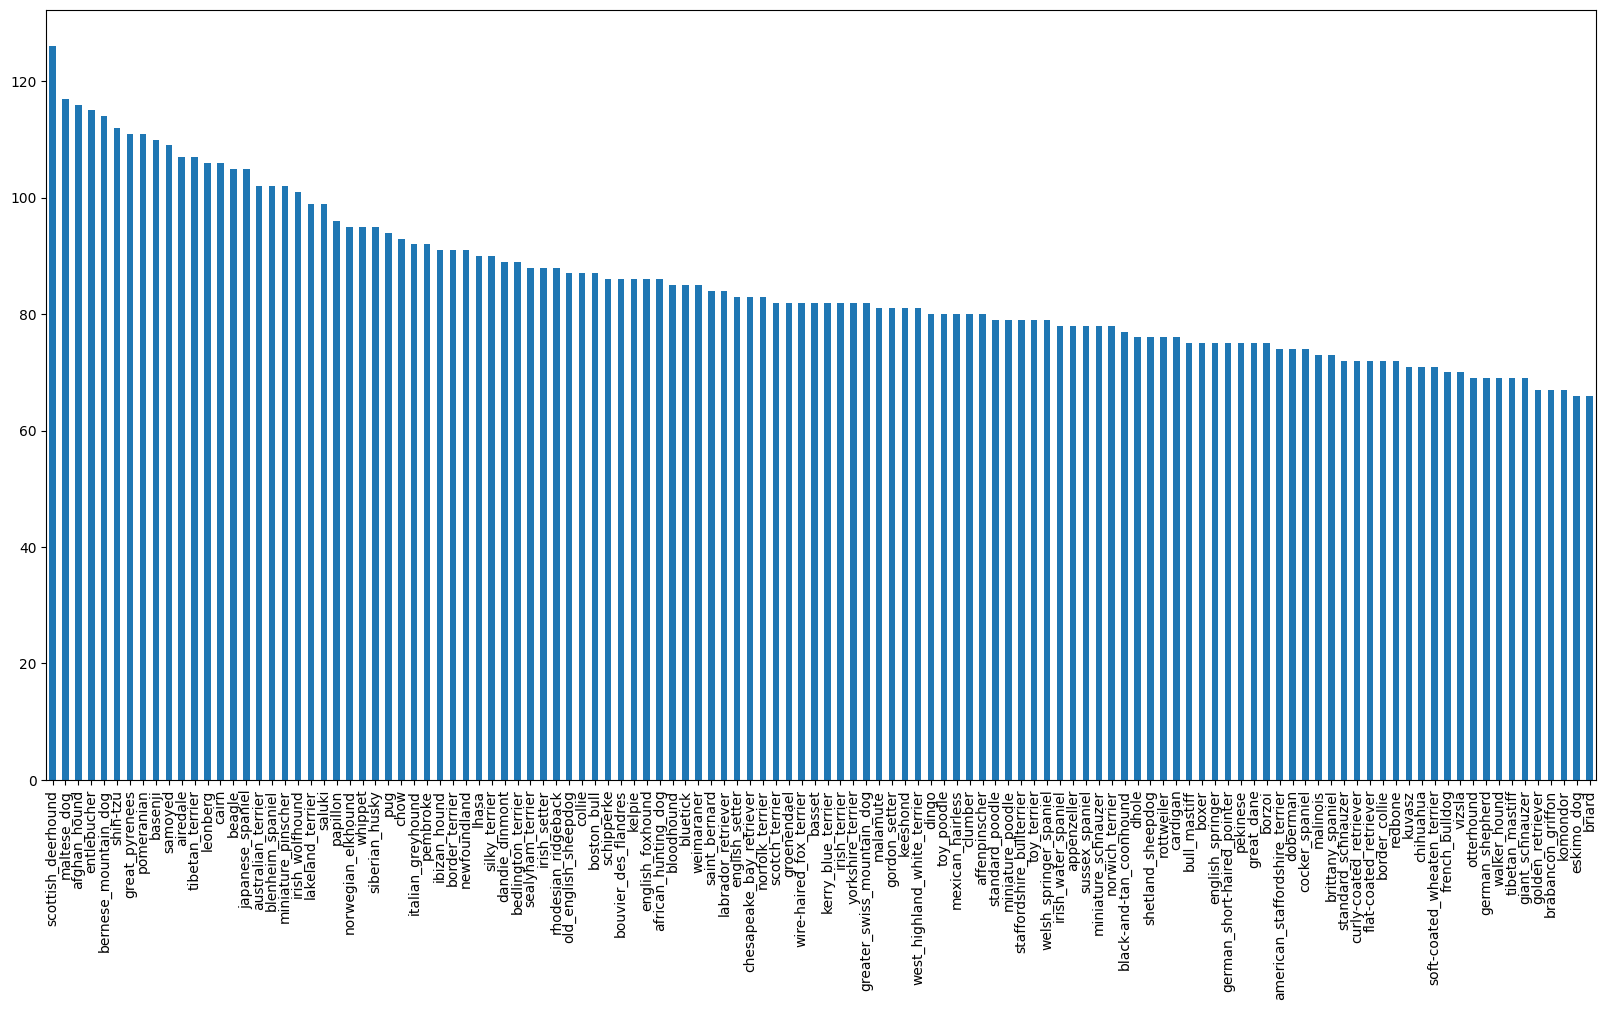

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
labels[0] == unique_breeds
boolean_labels = [label == np.array(unique_breeds) for label in labels]

In [ ]:
X = filenames
y = boolean_labels

NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                                        y[:NUM_IMAGES],
                                                                        test_size = 0.2,
                                                                        random_state = 42)

In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
# Define image size
IMG_SIZE = 224

# Function to preprocess images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read image
  image = tf.io.read_file(image_path)

  #Turn jpeg into a numerical Tensor with 3 colors
  image = tf.image.decode_jpeg(image, channels = 3)

  # Convert the color channel values from 0-255 to 0-1 values (normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize image to 224x224
  image = tf.image.resize(image, size = (IMG_SIZE, IMG_SIZE))

  return image

In [ ]:
# Create function to return a tuple of tensors
def get_image_label(image_path, label):
  """
  Takes image and its label, processes the image and returns a tuple of both.
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Define batch size
BATCH_SIZE = 32

# Function to turn data into (X, y) batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Create batches of data out of image X and label y pairs. It shuffles data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels.)
  """
  # If the test data is a test dataset, we probably don't have labels
  if test_data:
     print("Creating test data batches...")
     data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
     data_batch = data.map(process_image).batch(BATCH_SIZE)
     return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
     print("Creating validation data batches...")
     data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                                          tf.constant(y)))
     data_batch = data.map(get_image_label).batch(BATCH_SIZE)
     return data_batch

  else:
      print("Creating training data batches...")
      #Turn filepaths and labels into Tensors
      data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                                          tf.constant(y)))
      # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
      data = data.shuffle(buffer_size = len(X))

  # Create (image,label) tuples
  data = data.map(get_image_label)

  # Create training data batches
  data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Function to view images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Figure setup
  plt.figure(figsize = (10,10))
  # Loop through 25
  for i in range(25):
    # Create subplot
    ax = plt.subplot(5, 5, i+1)
    # Display image
    plt.imshow(images[i])
    # Add image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn grid lines off
    plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

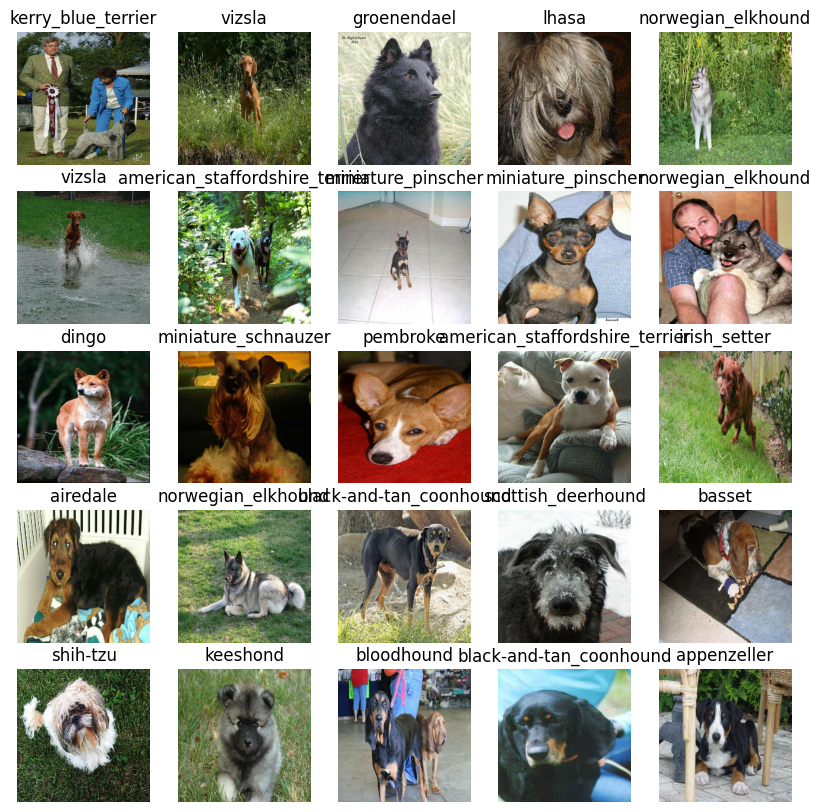

In [ ]:
show_25_images(train_images, train_labels)

In [ ]:
import tensorflow_hub as hub

# Input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Output shape
OUTPUT_SHAPE = len(unique_breeds)

# Model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
# Function that builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
   model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # layer 1 - input layer
      tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                                       activation = "softmax")  # layer 2 - output layer
   ])

   # Compile the model
   model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
   )

   #Build model
   model.build(INPUT_SHAPE)
   return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
outputs = np.ones(shape = (1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

# Creating callbacks

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
import os
# Create a function to create a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Dog breed identification/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                                patience = 3)

# Training a model

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Function which trains a model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create model
  model = create_model()

  # Create a new TensorBoard session everytime a model is trained
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
                 epochs = NUM_EPOCHS,
                 validation_data = val_data,
                  validation_freq = 1,
                  callbacks = [tensorboard, early_stopping])

  return model

In [ ]:
model = train_model()

Epoch 1/100
25/25 [==============================] - 324s 13s/step - loss: 4.4418 - accuracy: 0.0975 - val_loss: 3.2491 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 4s 149ms/step - loss: 1.5615 - accuracy: 0.7075 - val_loss: 2.1077 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 3s 103ms/step - loss: 0.5343 - accuracy: 0.9550 - val_loss: 1.6254 - val_accuracy: 0.6150
Epoch 4/100
25/25 [==============================] - 3s 102ms/step - loss: 0.2337 - accuracy: 0.9925 - val_loss: 1.4495 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 3s 109ms/step - loss: 0.1386 - accuracy: 0.9987 - val_loss: 1.3892 - val_accuracy: 0.6450
Epoch 6/100
25/25 [==============================] - 3s 109ms/step - loss: 0.0969 - accuracy: 0.9987 - val_loss: 1.3434 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================] - 3s 109ms/step - loss: 0.0727 - accuracy: 1.0000 - val_loss: 1.3178 - val_accuracy: 0.6450

# Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on validation data
predictions = model.predict(val_data, verbose = 1)
len(predictions)

7/7 [==============================] - 1s 77ms/step


200

In [ ]:
np.sum(predictions[0])

1.0

In [ ]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value of prediction probability: {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label:{unique_breeds[np.argmax(predictions[index])]}")

[1.55789638e-03 3.22222731e-05 1.11092778e-03 1.03868566e-04
 8.80273583e-05 1.39833837e-05 3.67937759e-02 3.45265085e-04
 1.61381194e-03 6.35782897e-04 1.57287030e-03 1.64905679e-04
 6.12205709e-04 4.96102984e-05 2.65286129e-04 4.62792726e-04
 3.98337361e-05 2.75190204e-01 6.00188241e-06 3.52067582e-05
 1.12259549e-04 1.31096604e-04 4.02734295e-05 9.82099373e-05
 3.25888905e-05 9.29446469e-05 8.85528997e-02 3.17925551e-05
 7.41429394e-04 1.60160271e-04 2.88476622e-05 5.83856367e-04
 1.72616230e-04 4.21330769e-05 2.58906584e-05 3.78994010e-02
 1.36723474e-05 1.46272112e-04 4.46613412e-05 1.61682721e-04
 2.25164648e-03 4.43254103e-05 1.25004823e-04 4.00014251e-05
 8.53672973e-05 6.47694396e-04 1.41891287e-05 2.27880621e-04
 1.31726242e-03 8.77090060e-05 2.18545611e-04 1.01757134e-04
 3.51785391e-04 1.05993480e-04 2.64652845e-05 3.51479503e-05
 2.67676241e-05 3.21355369e-03 2.72429053e-04 1.77354172e-01
 1.73918423e-04 6.70653662e-06 8.72321078e-04 9.80695950e-06
 3.10342934e-04 1.368236

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

# Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% ({})".format(pred_label, np.max(pred_prob)*100, true_label), color = color)

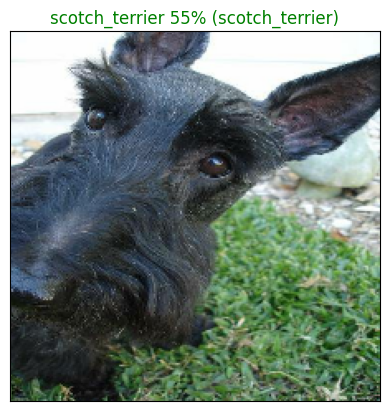

In [ ]:
plot_pred(prediction_probabilities=predictions, labels = val_labels, images = val_images)

In [ ]:
def pred_plot_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                               top_10_pred_values,
                               color = "grey" )
  plt.xticks(np.arange(len(top_10_pred_labels)),
                 labels = top_10_pred_labels,
                 rotation = "vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

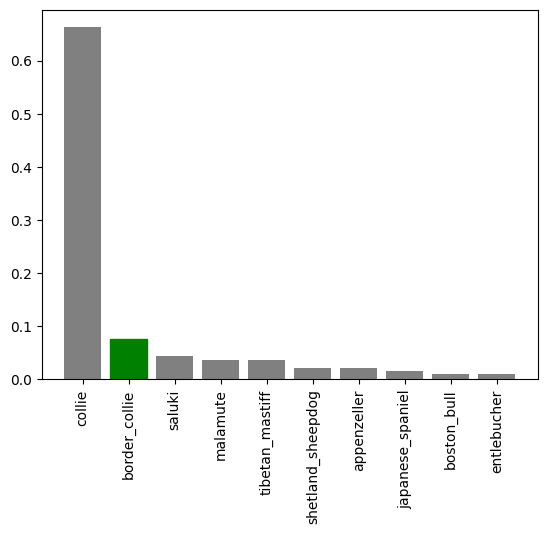

In [ ]:
pred_plot_conf(prediction_probabilities = predictions, labels = val_labels, n=9)

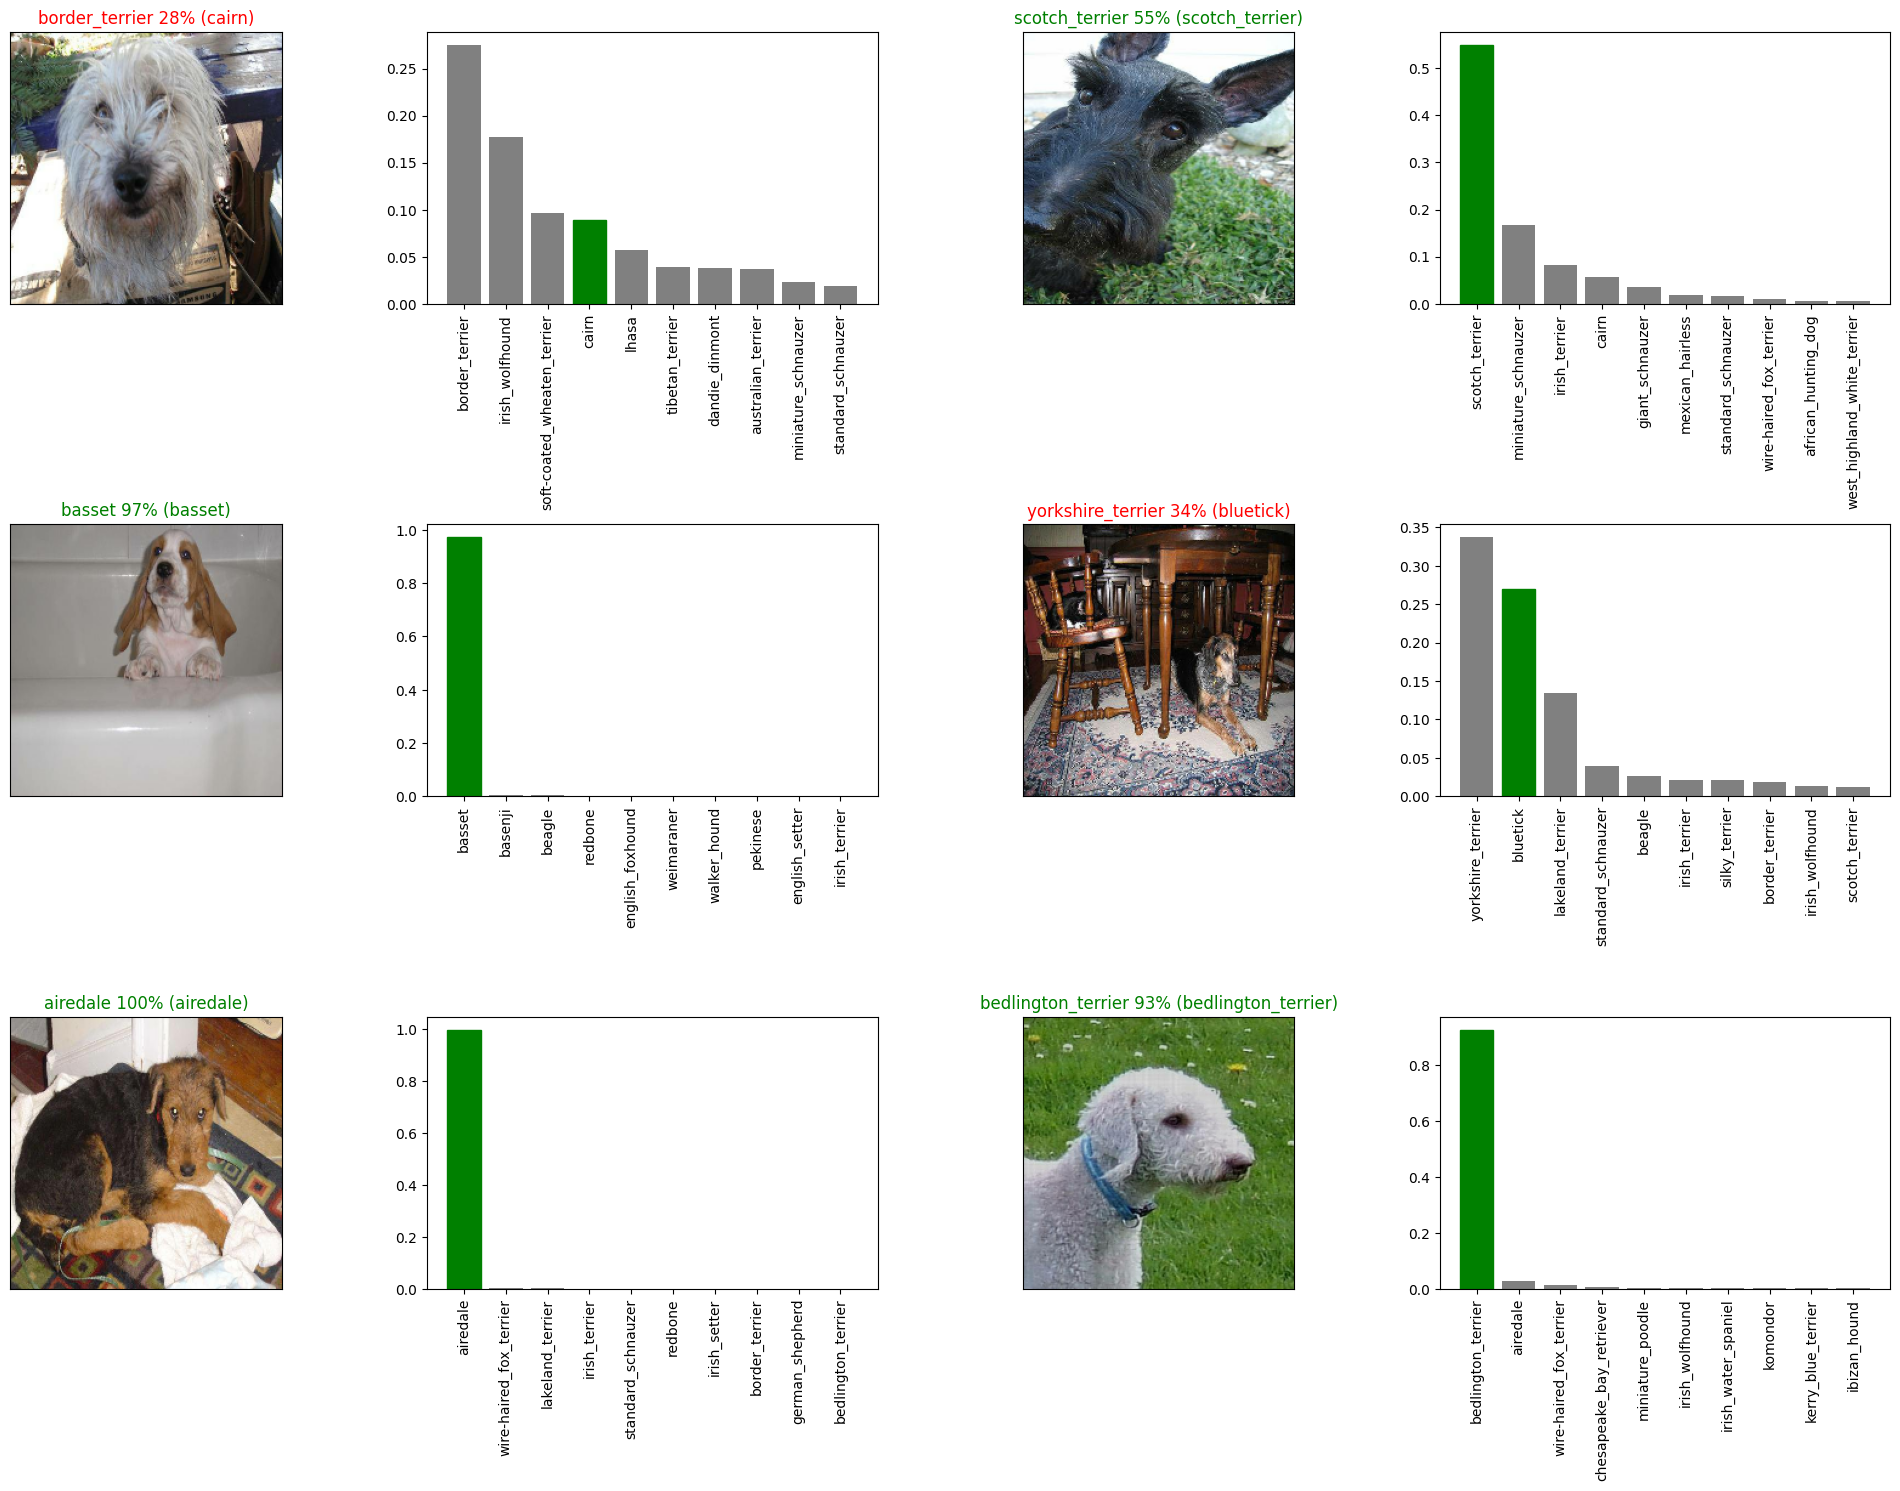

In [ ]:
i_multiplier = 0
n_rows = 3
n_cols = 2
num_images = n_rows * n_cols
plt.figure(figsize = (10*n_cols, 5*n_rows))
for i in range(num_images):
   plt.subplot(n_rows, 2*n_cols, 2*i+1)
   plot_pred(prediction_probabilities = predictions,
                   labels = val_labels,
                   images = val_images,
                   n = i+i_multiplier)
   plt.subplot(n_rows, 2*n_cols, 2*i+2)
   pred_plot_conf(prediction_probabilities = predictions,
                   labels = val_labels,
                   n = i+i_multiplier)
plt.tight_layout(h_pad = 1.0)
plt.show()

# Saving and loading a model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string).
  """
  modeldir = os.path.join("/content/drive/MyDrive/Dog breed identification/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".keras"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading model from: {model_path}...")
  tf.keras.models.load_model(model_path, custom_objects = {"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model, suffix = "1000-img-adam")

Saving model to: /content/drive/MyDrive/Dog breed identification/models/20231024-11561698148586-1000-img-adam.keras...


'/content/drive/MyDrive/Dog breed identification/models/20231024-11561698148586-1000-img-adam.keras'

In [ ]:
a = load_model("/content/drive/MyDrive/Dog breed identification/models/20231024-11561698148586-1000-img-adam.keras")

Loading model from: /content/drive/MyDrive/Dog breed identification/models/20231024-11561698148586-1000-img-adam.keras...


# Training a model in a full dataset

In [ ]:
# Data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
# Create a model for full model
full_model = create_model()

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

In [ ]:
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "accuracy", patience = 3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 77s 229ms/step - loss: 0.4922 - accuracy: 0.8570
Epoch 2/100
320/320 [==============================] - 29s 90ms/step - loss: 0.2658 - accuracy: 0.9235
Epoch 3/100
320/320 [==============================] - 30s 93ms/step - loss: 0.1665 - accuracy: 0.9592
Epoch 4/100
320/320 [==============================] - 29s 90ms/step - loss: 0.1126 - accuracy: 0.9781
Epoch 5/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0820 - accuracy: 0.9854
Epoch 6/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0599 - accuracy: 0.9926
Epoch 7/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0469 - accuracy: 0.9935
Epoch 8/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0390 - accuracy: 0.9958
Epoch 9/100
320/320 [==============================] - 31s 95ms/step - loss: 0.0320 - accuracy: 0.9968
Epoch 10/100
320/320 [==============================] - 29s 91ms/step - 

In [ ]:
save_model(full_model, suffix = "fully trained model")

Saving model to: /content/drive/MyDrive/Dog breed identification/models/20231024-13251698153951-fully trained model.keras...


'/content/drive/MyDrive/Dog breed identification/models/20231024-13251698153951-fully trained model.keras'

In [ ]:
loaded_full_model = load_model("/content/drive/MyDrive/Dog breed identification/models/20231024-13251698153951-fully trained model.keras")

Loading model from: /content/drive/MyDrive/Dog breed identification/models/20231024-13251698153951-fully trained model.keras...


# Making predictions on the test data set

In [ ]:
# Load test image filenames
test_path = "/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/e5e51d0dfc3ccdb74de51933b2671742.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/e53b2f4211fb7a34aeaa04974b919f6d.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/e5507ebc0e05513bf543e160a484666f.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/e386eaa78980be7183ecfdd32ecd2aab.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/de85fdcf74dbe025b9b89819735cb9bc.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/e73dc6a8f2d7c941f28c0a5298bc5bdc.jpg',
 '/content/drive/MyDrive/Dog breed identification/dog-breed-identification.zip (Unzipped Files)/test/e4369279919beecfb6d91a5375bc122f.jpg',
 '/content/drive/MyD

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [ ]:
# Make predictions on test data batch with full model
test_predictions = loaded_full_model.predict(test_data, verbose = 1)

324/324 [==============================] - 4132s 13s/step


In [ ]:
# Save predictions as NumPy array/csv for later access
np.savetxt("/content/drive/MyDrive/Dog breed identification/preds_array.csv", test_predictions, delimiter = ",")

In [ ]:
# Load
test_predictions = np.loadtxt("/content/drive/MyDrive/Dog breed identification/preds_array.csv", delimiter = ",")
test_predictions[:5]

array([[9.91621782e-05, 1.25874911e-04, 1.92927328e-04, 1.95110188e-05,
        1.58105431e-05, 2.46098698e-05, 9.00336672e-05, 1.34213371e-06,
        1.80363554e-06, 8.27819974e-07, 2.29183547e-06, 2.66038769e-05,
        3.74238016e-06, 8.38192227e-06, 1.03986298e-04, 1.47920719e-05,
        3.45275544e-06, 3.24922032e-04, 9.91890738e-06, 8.03894454e-06,
        1.14994706e-04, 1.79758921e-04, 2.15535314e-04, 8.17164721e-04,
        8.63642163e-06, 1.35869792e-04, 9.74964059e-05, 6.19542843e-05,
        4.10154098e-05, 2.45807722e-04, 3.77967022e-03, 1.06937059e-05,
        9.30781389e-05, 3.02441094e-05, 5.07060167e-06, 3.24565081e-05,
        1.61579592e-04, 3.14319259e-05, 7.85381271e-05, 6.75724095e-06,
        5.11329108e-06, 1.37940287e-05, 1.64744608e-06, 9.89712771e-06,
        2.01834609e-05, 5.41052214e-06, 3.70623427e-04, 1.50123396e-05,
        1.16121373e-05, 8.53257370e-06, 1.55296893e-05, 2.09651116e-05,
        1.27001127e-04, 3.53792325e-06, 1.42567779e-03, 4.369562